In [2]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/timoh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/timoh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import spacy
import numpy as np

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def extract_features(text):
    doc = nlp(text)
    
    # Sentence Length
    sentence_length = len(doc)
    
    # Dependency Labels
    dep_labels = [token.dep_ for token in doc]
    
    # Named Entity Tags
    named_entities = [ent.label_ for ent in doc.ents]
    num_named_entities = len(named_entities)
    
    # Averaging Word Embeddings
    # Note: Exclude out-of-vocabulary words and named entities
    embeddings = [token.vector for token in doc if not token.is_oov and not token.ent_type_]
    if embeddings:
        avg_embedding = np.mean(embeddings, axis=0)
    else:
        avg_embedding = np.zeros((len(doc.vocab.vectors),))
    
    # Add more features as needed
    
    return {
        'sentence_length': sentence_length,
        'dependency_labels': dep_labels,
        'num_named_entities': num_named_entities,
        'avg_embedding': avg_embedding
        # Include other feature representations here
    }

# Example usage
features = extract_features("Apple Inc. is an American multinational technology company headquartered in Cupertino, California.")
print(features)


{'sentence_length': 14, 'dependency_labels': ['compound', 'nsubj', 'ROOT', 'det', 'amod', 'amod', 'compound', 'attr', 'acl', 'prep', 'pobj', 'punct', 'appos', 'punct'], 'num_named_entities': 4, 'avg_embedding': array([], dtype=float64)}


In [24]:
import json

train_data = 'data/train.greedy_sent.json'
eval_data = 'data/validation.json'
test_data = 'data/test.json'

with open(train_data, 'r') as f:
    train_data = json.load(f)

with open(eval_data, 'r') as f:
    eval_data = json.load(f)
    
with open(test_data, 'r') as f:
    test_data = json.load(f)
    

In [27]:
train_articles = [article['article'] for article in train_data]
train_highlight_decisions = [article['greedy_n_best_indices'] for article in train_data]

eval_articles = [article['article'] for article in eval_data]
test_articles = [article['article'] for article in test_data]

In [28]:
import numpy as np

print(len(train_articles))
print(len(eval_articles))
print(len(test_articles))

10000
1000
1000


In [50]:
# average article length (# sentences)
split_articles = [[s.strip() for s in article.split('.')] for article in train_articles]
train_highlight_decisions = [article['greedy_n_best_indices'] for article in train_data]
print(np.mean([len(article) for article in split_articles]))

43.0585


In [51]:
sum(len(article) for article in split_articles)

430585

In [10]:
# average sentence length (# characters)
print(np.mean([len(sentence) for split_article in split_articles for sentence in split_article]))

91.84863383536351


In [11]:
# average number of 1s (kept sentences) for each article's gold label summary
print(np.mean([sum(sentence_labels) for sentence_labels in train_highlight_decisions]))

2.5733


In [12]:
mean_proportion_nonzero = np.mean([
    sum(1 for label in labels if label != 0) / len(article)
    for labels, article in zip(train_highlight_decisions, split_articles)
])
print(mean_proportion_nonzero)

0.07807726327559007


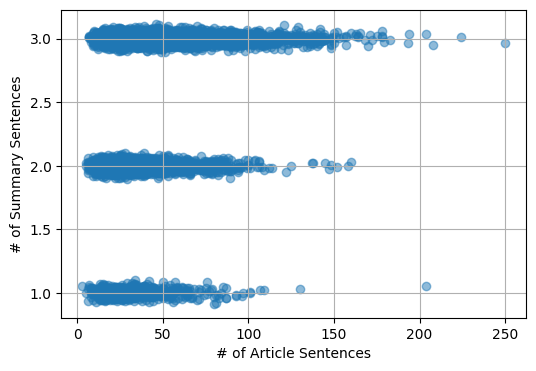

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a list of articles split into sentences (split_articles)
# and a corresponding list of label decisions (train_highlight_decisions)

# Calculate the number of sentences in each article
num_sentences = [len(article) for article in split_articles]

# Calculate the number of non-zero entries in the labels for each article
num_nonzero_labels = [sum(1 for label in labels if label != 0) for labels in train_highlight_decisions]

# Add random jitter to the y-values
# The scale of the jitter should be chosen according to the scale of the data
# Here, 0.1 is just an example value; you might need to adjust this
jitter = np.random.normal(0, 0.03, size=len(num_nonzero_labels))
num_nonzero_labels_jittered = np.array(num_nonzero_labels) + jitter

# Now we can create a scatter plot with this data
plt.figure(figsize=(6,4))  # Set the size of the figure
plt.scatter(num_sentences, num_nonzero_labels_jittered, alpha=0.5)  # Create a scatter plot with jitter
# plt.title('Number of Sentences in Article vs. Summary')  # Set the title of the plot
plt.xlabel('# of Article Sentences')  # Set the label for the x-axis
plt.ylabel('# of Summary Sentences')  # Set the label for the y-axis
plt.grid(True)  # Show grid
plt.show()  # Display the plot

In [15]:
mean_proportion_nonzero * 30


2.342317898267702

In [16]:
np.mean([len()])

TypeError: len() takes exactly one argument (0 given)

In [17]:
import string
from nltk.corpus import stopwords

# Function to remove punctuation from a sentence
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))


In [18]:
stop_words = set(stopwords.words('english'))

flat_words = [
    word
    for article in split_articles
    for sentence in article
    for word in remove_punctuation(sentence).lower().split()
    if word not in stop_words
]

In [52]:
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

def plot_word_counts(word_list, n):
    word_counts = Counter(word_list)
    most_common_counts = word_counts.most_common(n)
    words = [word for word, count in most_common_counts]
    counts = [count for word, count in most_common_counts]

    plt.figure(figsize=(15, 5))
    sns.barplot(x=words, y=counts, color='lightblue')

    plt.yscale('log')
    plt.ylabel('Count (log scale)')
    plt.xticks([])
    plt.title(f'Top {n} Word Counts')

    # Adding horizontal lines at y=10000, y=1000, and y=100 with different colors and labels for the legend
    line10000 = plt.axhline(y=10000, color='orange', linestyle='--', label='10,000')
    line1000 = plt.axhline(y=1000, color='green', linestyle='--', label='1,000')
    line100 = plt.axhline(y=100, color='purple', linestyle='--', label='100')

    # Adding a legend to the plot
    plt.legend()

    plt.show()

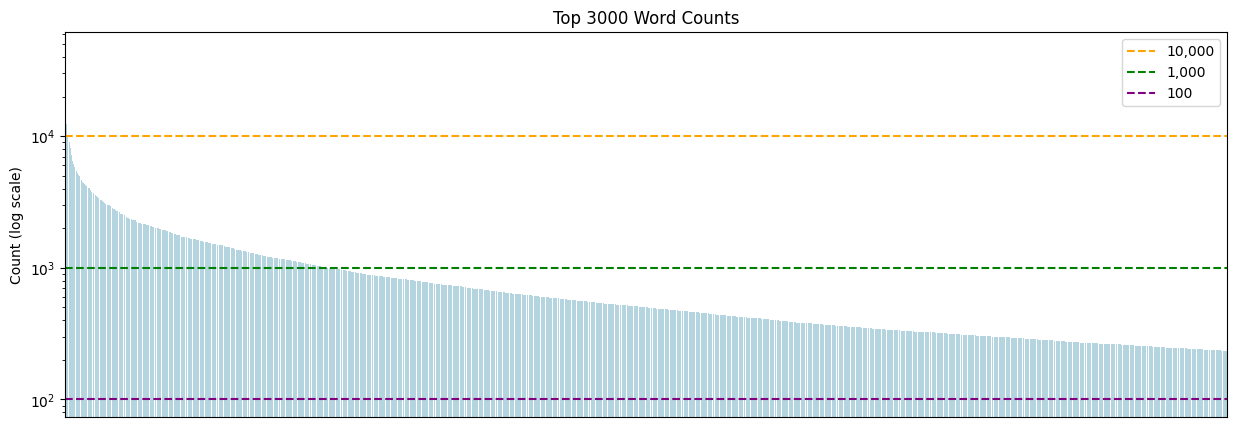

In [53]:
plot_word_counts(flat_words, 3000)

In [108]:
import os
import pickle

pkl_path = f'pickled_scores/embeddings_scores.pkl'

if os.path.exists(pkl_path):
    with open(pkl_path, 'rb') as file:
        sentence_scores = pickle.load(file)

In [116]:
[np.mean(article) for article in sentence_scores]

[0.057238792800019964,
 0.07230719441982962,
 0.08156402204899982,
 0.07807553543870271,
 0.060525311700862346,
 0.05851742065999781,
 0.07439511794267292,
 0.08473604683900815,
 0.15022370671687751,
 0.07715242201117133,
 0.07283666355517304,
 0.08357948164421418,
 0.09504347791206388,
 0.0524673617314183,
 0.13636488449225487,
 0.045105435911613506,
 0.06280521746607859,
 0.042536984278160585,
 0.08455296997612087,
 0.08461979052565906,
 0.07011707186120951,
 0.056948755172664546,
 0.07529235928695398,
 0.09154767218468791,
 0.05675603931510753,
 0.051579152368254964,
 0.06444070541205302,
 0.05214070008624309,
 0.07943458937018298,
 0.07971779992016527,
 0.12572524808711408,
 0.07383140131907578,
 0.07396490266017657,
 0.06948909033427007,
 0.04688195872526374,
 0.05701700575267465,
 0.058490977157824676,
 0.042381414792820725,
 0.08491295444091976,
 0.09078837841864208,
 0.09240013832832127,
 0.06056473205038125,
 0.07018506482666591,
 0.06419279231969714,
 0.04766561615908704,
 0.

In [4]:
import numpy as np
import pickle

with open('pickled_data/embeddings_train.pkl', 'rb') as f:
    embeddings = pickle.load(f)

In [6]:
# Assuming 'article_feature' is a list of vector embeddings

for article_feature in embeddings:
    article_feature = np.array(article_feature)  # Convert to a NumPy array if not already one

    # Normalize each vector to unit length
    norms = np.linalg.norm(article_feature, axis=1, keepdims=True)
    normalized_embeddings = article_feature / norms

    # Compute the cosine similarity matrix
    cosine_similarity_matrix = np.dot(normalized_embeddings, normalized_embeddings.T)


In [7]:
from sentence_transformers import SentenceTransformer
import tqdm

model = SentenceTransformer('paraphrase-MiniLM-L3-v2')

all_sentences = [
    "Hello, how are you?",
    "Today is a good day.",
    "Where are you going today?",
    "How have you been?",
    "The cat ate the orange dolphin.",
    "In algebraic topology, a discipline within mathematics, the acyclic models theorem can be used to show that two homology theories are isomorphic"
]

batch_size = 2048  # make sure batch can fit into python memory
features = []

# Iterate over batches of sentences
for batch_start in tqdm.tqdm(range(0, len(all_sentences), batch_size), desc='Computing Sentence-BERT embeddings'):
    batch_sentences = all_sentences[batch_start:batch_start + batch_size]
    batch_features = model.encode(
        batch_sentences,
        convert_to_tensor=False,
        show_progress_bar=False
    )
    features.extend(batch_features)

/home/timoh/L90-Summarization/summarizer_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Computing Sentence-BERT embeddings: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


In [8]:

article_feature = np.array(features)

norms = np.linalg.norm(article_feature, axis=1, keepdims=True)
normalized_embeddings = article_feature / norms

cosine_similarity_matrix = np.dot(normalized_embeddings, normalized_embeddings.T)

print(cosine_similarity_matrix.T)

[[ 0.9999998   0.26053205  0.4824577   0.49835312 -0.04441106  0.03032698]
 [ 0.26053205  0.9999994   0.5136187   0.08747116 -0.0263608   0.04621622]
 [ 0.4824577   0.5136187   0.9999999   0.38920525 -0.05296707 -0.0246569 ]
 [ 0.49835312  0.08747116  0.38920525  1.0000005  -0.03654645  0.04260694]
 [-0.04441106 -0.0263608  -0.05296707 -0.03654645  0.9999999  -0.09922751]
 [ 0.03032698  0.04621622 -0.0246569   0.04260694 -0.09922751  0.99999994]]


In [9]:
avg_sims = np.sum(cosine_similarity_matrix, axis=1)

In [10]:
avg_sims

array([2.2272587 , 1.8814768 , 2.3076575 , 1.9810905 , 0.74048704,
       0.99526566], dtype=float32)

In [12]:
avg_sims.argsort()

array([4, 5, 1, 3, 0, 2])

In [11]:
avg_sims

array([2.2272587 , 1.8814768 , 2.3076575 , 1.9810905 , 0.74048704,
       0.99526566], dtype=float32)

In [17]:
avg_sims = np.sum(cosine_similarity_matrix, axis=1)
indices = avg_sims.argsort()[::-1][:3]

In [18]:
all_sentences = [all_sentences[i] for i in indices]

In [19]:
all_sentences

['Where are you going today?', 'Hello, how are you?', 'How have you been?']

In [85]:
import pandas as pd

df = pd.read_csv('results.csv')
df_filtered = df[['run_name', 'rouge-1-f', 'rouge-2-f', 'rouge-su*-f']]
df_float = df.select_dtypes(include=['float'])
df[df_float.columns] = df_float.round(3)

In [86]:
df


,rouge-1-r,rouge-1-p,rouge-1-f,rouge-2-r,rouge-2-p,rouge-2-f,rouge-4-r,rouge-4-p,rouge-4-f,rouge-l-r,...,rouge-w-1.2-r,rouge-w-1.2-p,rouge-w-1.2-f,rouge-s*-r,rouge-s*-p,rouge-s*-f,rouge-su*-r,rouge-su*-p,rouge-su*-f,run_name
0,0.455,0.185,0.263,0.179,0.069,0.100,0.060,0.024,0.035,0.381,...,0.163,0.114,0.134,0.210,0.037,0.063,0.220,0.041,0.069,tfidf_test
1,0.448,0.193,0.270,0.183,0.073,0.105,0.062,0.025,0.036,0.378,...,0.161,0.119,0.137,0.210,0.041,0.068,0.220,0.044,0.074,embeddings_eval
2,0.459,0.188,0.267,0.187,0.074,0.106,0.064,0.027,0.038,0.384,...,0.165,0.118,0.137,0.217,0.040,0.068,0.227,0.044,0.074,embeddings_test
3,0.456,0.193,0.272,0.183,0.074,0.106,0.064,0.028,0.038,0.384,...,0.163,0.119,0.138,0.211,0.041,0.068,0.221,0.044,0.074,tfidf_eval
4,0.154,0.217,0.180,0.040,0.055,0.046,0.013,0.020,0.016,0.132,...,0.059,0.149,0.085,0.029,0.051,0.037,0.034,0.064,0.045,custom_eval
5,0.150,0.206,0.174,0.038,0.051,0.044,0.012,0.016,0.013,0.129,...,0.058,0.141,0.082,0.029,0.047,0.036,0.034,0.060,0.043,custom_test
6,0.199,0.201,0.200,0.039,0.040,0.040,0.009,0.009,0.009,0.166,...,0.073,0.124,0.092,0.034,0.036,0.035,0.041,0.043,0.042,custom_pairwise_test
7,0.194,0.208,0.201,0.039,0.043,0.041,0.010,0.011,0.011,0.163,...,0.072,0.129,0.092,0.034,0.040,0.036,0.040,0.046,0.043,custom_pairwise_eval
8,0.274,0.258,0.266,0.090,0.080,0.085,0.033,0.029,0.031,0.229,...,0.101,0.161,0.124,0.075,0.065,0.069,0.083,0.072,0.077,tidf_pairwise_eval
9,0.281,0.249,0.264,0.096,0.081,0.088,0.034,0.029,0.031,0.238,...,0.105,0.159,0.127,0.079,0.061,0.069,0.087,0.068,0.077,tidf_pairwise_test


In [88]:
latex_table = df.to_latex(index=False, float_format="%.2f")  # Set 'index=False' if you don't want DataFrame's index in the table
print(latex_table)

\begin{tabular}{rrrrrrrrrrrrrrrrrrrrrl}
\toprule
rouge-1-r & rouge-1-p & rouge-1-f & rouge-2-r & rouge-2-p & rouge-2-f & rouge-4-r & rouge-4-p & rouge-4-f & rouge-l-r & rouge-l-p & rouge-l-f & rouge-w-1.2-r & rouge-w-1.2-p & rouge-w-1.2-f & rouge-s*-r & rouge-s*-p & rouge-s*-f & rouge-su*-r & rouge-su*-p & rouge-su*-f & run_name \\
\midrule
0.46 & 0.18 & 0.26 & 0.18 & 0.07 & 0.10 & 0.06 & 0.02 & 0.04 & 0.38 & 0.15 & 0.22 & 0.16 & 0.11 & 0.13 & 0.21 & 0.04 & 0.06 & 0.22 & 0.04 & 0.07 & tfidf_test \\
0.45 & 0.19 & 0.27 & 0.18 & 0.07 & 0.10 & 0.06 & 0.03 & 0.04 & 0.38 & 0.16 & 0.23 & 0.16 & 0.12 & 0.14 & 0.21 & 0.04 & 0.07 & 0.22 & 0.04 & 0.07 & embeddings_eval \\
0.46 & 0.19 & 0.27 & 0.19 & 0.07 & 0.11 & 0.06 & 0.03 & 0.04 & 0.38 & 0.16 & 0.23 & 0.17 & 0.12 & 0.14 & 0.22 & 0.04 & 0.07 & 0.23 & 0.04 & 0.07 & embeddings_test \\
0.46 & 0.19 & 0.27 & 0.18 & 0.07 & 0.11 & 0.06 & 0.03 & 0.04 & 0.38 & 0.16 & 0.23 & 0.16 & 0.12 & 0.14 & 0.21 & 0.04 & 0.07 & 0.22 & 0.04 & 0.07 & tfidf_eval \\
0.1